In [1]:
# %%
from Customer import *
from UserClass import *
from UCB1_Learner import *
from Non_Stationary_Environment import *
from SWUCB_Learner import *
from CDUCB_Learner import *
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt

n_arms = 5

customers = []

customers.append(Customer('C1', -1.5, 0.1, 100, [0.95,0.70,0.53,0.28,0.14]))
customers.append(Customer('C2', -0.5, -1.5, 80,[0.8,0.78,0.63,0.48,0.3]))
customers.append(Customer('C3', -5, 0.3, 65,[0.7,0.6,0.41,0.22,0.1]))

c1 = UserClass(
    np.array([10, 20, 30, 40, 50]),
    np.array([
        [0.95, 0.70, 0.53, 0.28, 0.14],
        [0.80, 0.65, 0.43, 0.15, 0.05],
        [0.75, 0.64, 0.26, 0.12, 0.02]
    ])
)

prb = (c1.prices - 8) * c1.probabilities
best_gain = prb.max(axis=1)

clicks = int(customers[0].num_clicks(2))
cost = customers[0].cum_cost_clicks(2)
margin = c1.prices - 8
rewards = (margin * c1.probabilities - cost) * clicks

T = 365
n_phases = 3
phases_len = int(T / n_phases)
n_experiments = 30
M = 50
eps = 0.15
h = 2 * np.log(T)
alpha = np.sqrt(0.5 * np.log(T) / T)

ucb1_rewards_per_experiment = []
swucb_w1_rewards_per_experiment = []
swucb_w2_rewards_per_experiment = []
swucb_w3_rewards_per_experiment = []
cducb_rewards_per_experiment = []

for e in range(0, n_experiments):
    ucb1_env = Non_Stationary_Environment(c1.probabilities, T, n_phases)
    swucb_w1_env = Non_Stationary_Environment(c1.probabilities, T, n_phases)
    swucb_w2_env = Non_Stationary_Environment(c1.probabilities, T, n_phases)
    swucb_w3_env = Non_Stationary_Environment(c1.probabilities, T, n_phases)
    cducb_env = Non_Stationary_Environment(c1.probabilities, T, n_phases)

    ucb1_learner = UCB1_Learner(n_arms, c1.prices, margin, clicks, cost)
    swucb_learner_w1 = SWUCB_Learner(n_arms, c1.prices, int(0.5 * sqrt(T)), margin, clicks, cost)
    swucb_learner_w2 = SWUCB_Learner(n_arms, c1.prices, int(sqrt(T)), margin, clicks, cost)
    swucb_learner_w3 = SWUCB_Learner(n_arms, c1.prices, int(3 * sqrt(T)), margin, clicks, cost)
    cducb_learner = CDUCB_Learner(n_arms, c1.prices, M, eps, h, alpha, margin, clicks, cost)

    for t in range(0, T):
        # UCB1
        pulled_arm = ucb1_learner.pull_arm()
        reward = ucb1_env.round(pulled_arm, clicks)
        ucb1_learner.update(pulled_arm, reward)

        # SWUCB1 window size = 0.5 * T
        pulled_arm = swucb_learner_w1.pull_arm()
        reward = swucb_w1_env.round(pulled_arm, clicks)
        swucb_learner_w1.update(pulled_arm, reward)

        # SWUCB1 window size = sqrt(T)
        pulled_arm = swucb_learner_w2.pull_arm()        
        reward = swucb_w2_env.round(pulled_arm, clicks)
        swucb_learner_w2.update(pulled_arm, reward)

        # SWUCB1 window size = log(T)
        pulled_arm = swucb_learner_w3.pull_arm()
        reward = swucb_w3_env.round(pulled_arm, clicks)
        swucb_learner_w3.update(pulled_arm, reward)

        # CUSUM UCB
        pulled_arm = cducb_learner.pull_arm()
        reward = cducb_env.round(pulled_arm, clicks)
        cducb_learner.update(pulled_arm, reward)

    ucb1_rewards_per_experiment.append(ucb1_learner.collected_rewards)
    swucb_w1_rewards_per_experiment.append(swucb_learner_w1.collected_rewards)
    swucb_w2_rewards_per_experiment.append(swucb_learner_w2.collected_rewards)
    swucb_w3_rewards_per_experiment.append(swucb_learner_w3.collected_rewards)
    cducb_rewards_per_experiment.append(cducb_learner.collected_rewards)

ucb1_rewards_per_experiment = np.array(ucb1_rewards_per_experiment)
swucb_w1_rewards_per_experiment = np.array(swucb_w1_rewards_per_experiment)
swucb_w2_rewards_per_experiment = np.array(swucb_w2_rewards_per_experiment)
swucb_w3_rewards_per_experiment = np.array(swucb_w3_rewards_per_experiment)
cducb_rewards_per_experiment = np.array(cducb_rewards_per_experiment)

ucb1_regret = np.zeros(T)
swucb_w1_regret = np.zeros(T)
swucb_w2_regret = np.zeros(T)
swucb_w3_regret = np.zeros(T)
cducb_regret = np.zeros(T)

ucb1_std= np.zeros(T)
swucb_w1_std = np.zeros(T)
swucb_w2_std = np.zeros(T)
swucb_w3_std = np.zeros(T)
cducb_std = np.zeros(T)

opt_per_phase = rewards.max(axis=1)
optimum_per_round = np.zeros(T)

for i in range(n_phases):
    t_index = range(i * phases_len, (i + 1) * phases_len)
    optimum_per_round[t_index] = opt_per_phase[i]

    # Regret
    ucb1_regret[t_index] = np.mean(opt_per_phase[i] - ucb1_rewards_per_experiment, axis=0)[t_index]
    swucb_w1_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w1_rewards_per_experiment, axis=0)[t_index]
    swucb_w2_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w2_rewards_per_experiment, axis=0)[t_index]
    swucb_w3_regret[t_index] = np.mean(opt_per_phase[i] - swucb_w3_rewards_per_experiment, axis=0)[t_index]
    cducb_regret[t_index] = np.mean(opt_per_phase[i] - cducb_rewards_per_experiment, axis=0)[t_index]

    # Standard deviation instantaneous regret
    ucb1_std[t_index] = np.std(opt_per_phase[i] - ucb1_rewards_per_experiment, axis=0)[t_index]
    swucb_w1_std[t_index] = np.std(opt_per_phase[i] - swucb_w1_rewards_per_experiment, axis=0)[t_index]
    swucb_w2_std[t_index] = np.std(opt_per_phase[i] - swucb_w2_rewards_per_experiment, axis=0)[t_index]
    swucb_w3_std[t_index] = np.std(opt_per_phase[i] - swucb_w3_rewards_per_experiment, axis=0)[t_index]
    cducb_std[t_index] = np.std(opt_per_phase[i] - cducb_rewards_per_experiment, axis=0)[t_index]

ucb1_label = "Stationary UCB1"
swucb_w1_label = r"$SW\ UCB1,\ window\ size=\frac{1}{2}\ T$"
swucb_w2_label = r"$SW\ UCB1,\ window\ size=\sqrt{T}$"
swucb_w3_label = r"$SW\ UCB1,\ window\ size=\log{T}$"
cducb_label = "CUSUM UCB1"

x = list(range(0,T))
stducb = [(np.cumsum(ucb1_regret))[:i].std() for i in range(1, T + 1)]
stdswucb_w1 = [(np.cumsum(swucb_w1_regret))[:i].std() for i in range(1, T + 1)]
stdswucb_w2 = [(np.cumsum(swucb_w2_regret))[:i].std() for i in range(1, T + 1)]
stdswucb_w3 = [(np.cumsum(swucb_w3_regret))[:i].std() for i in range(1, T + 1)]
stdcducb = [(np.cumsum(cducb_regret))[:i].std() for i in range(1, T + 1)]

sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
s

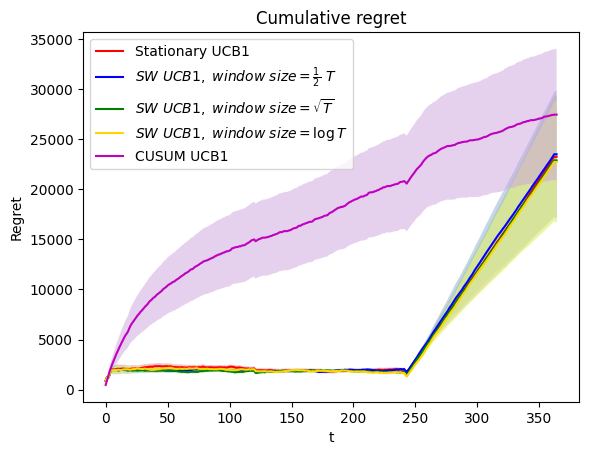

In [2]:
# %%
# Cumulative regret
plt.figure("Cumulative regret")
plt.title("Cumulative regret")
plt.xlabel('t')
plt.ylabel('Regret')
plt.plot(np.cumsum(ucb1_regret), 'r', label=ucb1_label)
plt.plot(np.cumsum(swucb_w1_regret), 'b', label=swucb_w1_label)
plt.plot(np.cumsum(swucb_w2_regret), 'g', label=swucb_w2_label)
plt.plot(np.cumsum(swucb_w3_regret), 'gold', label=swucb_w3_label)
plt.plot(np.cumsum(cducb_regret), 'm', label=cducb_label)

plt.fill_between(x, np.cumsum(ucb1_regret)+stducb, np.cumsum(ucb1_regret)-stducb,
    alpha=0.5, facecolor='#DA8E8B',
    linewidth=0)

plt.fill_between(x, np.cumsum(swucb_w1_regret)+stdswucb_w1, np.cumsum(swucb_w1_regret)-stdswucb_w1,
    alpha=0.5, facecolor='#8DAFD3',
    linewidth=0)

plt.fill_between(x, np.cumsum(swucb_w2_regret)+stdswucb_w2, np.cumsum(swucb_w2_regret)-stdswucb_w2,
    alpha=0.5, facecolor='#A1ECA7',
    linewidth=0)

plt.fill_between(x, np.cumsum(swucb_w3_regret)+stdswucb_w3, np.cumsum(swucb_w3_regret)-stdswucb_w3,
    alpha=0.5, facecolor='#FEF580',
    linewidth=0)

plt.fill_between(x, np.cumsum(cducb_regret)+stdcducb, np.cumsum(cducb_regret)-stdcducb,
    alpha=0.5, facecolor='#CDA4DE',
    linewidth=0)

plt.legend(loc=0)
plt.show()

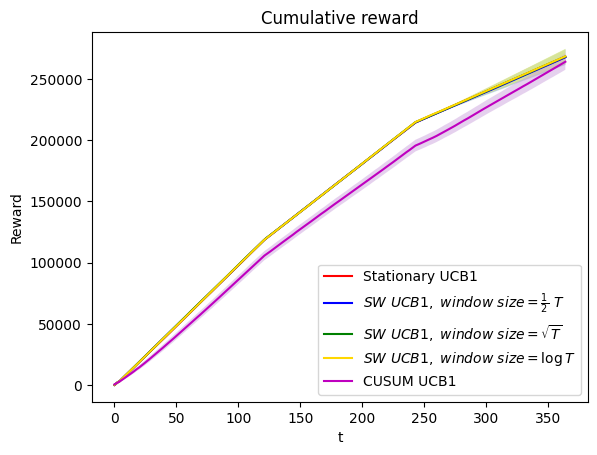

In [3]:
# %%
# Cumulative reward
ucb1_cum_mean = np.cumsum(np.mean(ucb1_rewards_per_experiment, axis=0))
swucb_w1_cum_mean = np.cumsum(np.mean(swucb_w1_rewards_per_experiment, axis=0))
swucb_w2_cum_mean = np.cumsum(np.mean(swucb_w2_rewards_per_experiment, axis=0))
swucb_w3_cum_mean = np.cumsum(np.mean(swucb_w3_rewards_per_experiment, axis=0))
cducb_cum_mean = np.cumsum(np.mean(cducb_rewards_per_experiment, axis=0))

plt.figure("Cumulative reward")
plt.title("Cumulative reward")
plt.xlabel('t')
plt.ylabel('Reward')
plt.plot(ucb1_cum_mean, 'r', label=ucb1_label)
plt.plot(swucb_w1_cum_mean, 'b', label=swucb_w1_label)
plt.plot(swucb_w2_cum_mean, 'g', label=swucb_w2_label)
plt.plot(swucb_w3_cum_mean, 'gold', label=swucb_w3_label)
plt.plot(cducb_cum_mean, 'm', label=cducb_label)

plt.fill_between(x, ucb1_cum_mean+stducb, ucb1_cum_mean-stducb,
    alpha=0.5, facecolor='#DA8E8B',
    linewidth=0)

plt.fill_between(x, swucb_w1_cum_mean+stdswucb_w1, swucb_w1_cum_mean-stdswucb_w1,
    alpha=0.5, facecolor='#8DAFD3',
    linewidth=0)

plt.fill_between(x, swucb_w2_cum_mean+stdswucb_w2, swucb_w2_cum_mean-stdswucb_w2,
    alpha=0.5, facecolor='#A1ECA7',
    linewidth=0)

plt.fill_between(x, swucb_w3_cum_mean+stdswucb_w3, swucb_w3_cum_mean-stdswucb_w3,
    alpha=0.5, facecolor='#FEF580',
    linewidth=0)

plt.fill_between(x, cducb_cum_mean+stdcducb, cducb_cum_mean-stdcducb,
    alpha=0.5, facecolor='#CDA4DE',
    linewidth=0)

plt.legend(loc=0)
plt.show()

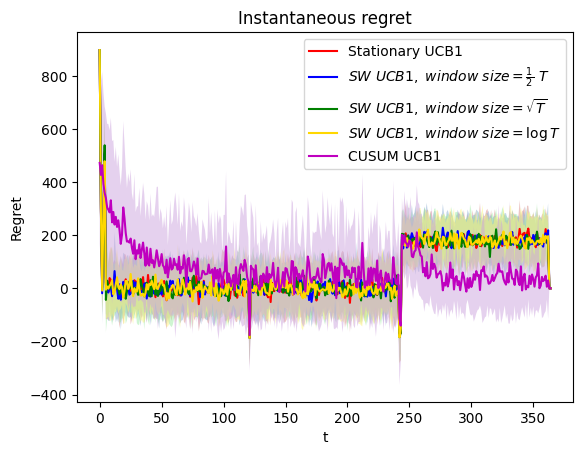

In [4]:
# %%
# Instantaneous regret

plt.figure("Instantaneous regret")
plt.title("Instantaneous regret")
plt.xlabel('t')
plt.ylabel('Regret')
plt.plot(ucb1_regret, 'r', label=ucb1_label)
plt.plot(swucb_w1_regret, 'b', label=swucb_w1_label)
plt.plot(swucb_w2_regret, 'g', label=swucb_w2_label)
plt.plot(swucb_w3_regret, 'gold', label=swucb_w3_label)
plt.plot(cducb_regret, 'm', label=cducb_label)

plt.fill_between(x, ucb1_regret+ucb1_std, ucb1_regret-ucb1_std,
    alpha=0.5, facecolor='#DA8E8B',
    linewidth=0)

plt.fill_between(x, swucb_w1_regret+swucb_w1_std, swucb_w1_regret-swucb_w1_std,
    alpha=0.5, facecolor='#8DAFD3',
    linewidth=0)

plt.fill_between(x, swucb_w2_regret+swucb_w2_std, swucb_w2_regret-swucb_w2_std,
    alpha=0.5, facecolor='#A1ECA7',
    linewidth=0)

plt.fill_between(x, swucb_w3_regret+swucb_w3_std, swucb_w3_regret-swucb_w3_std,
    alpha=0.5, facecolor='#FEF580',
    linewidth=0)

plt.fill_between(x, cducb_regret+cducb_std, cducb_regret-cducb_std,
    alpha=0.5, facecolor='#CDA4DE',
    linewidth=0)

plt.legend(loc=0)
plt.show()

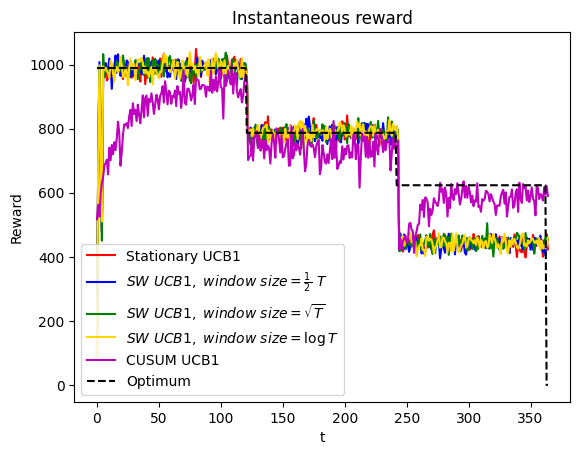

In [5]:
# %%
# Instantaneous reward
plt.figure("Instantaneous reward")
plt.title("Instantaneous reward")
plt.xlabel('t')
plt.ylabel('Reward')
plt.plot(np.mean(ucb1_rewards_per_experiment, axis=0), 'r', label=ucb1_label)
plt.plot(np.mean(swucb_w1_rewards_per_experiment, axis=0), 'b', label=swucb_w1_label)
plt.plot(np.mean(swucb_w2_rewards_per_experiment, axis=0), 'g', label=swucb_w2_label)
plt.plot(np.mean(swucb_w3_rewards_per_experiment, axis=0), 'gold', label=swucb_w3_label)
plt.plot(np.mean(cducb_rewards_per_experiment, axis=0), 'm', label=cducb_label)
plt.plot(optimum_per_round, 'k--', label="Optimum")
plt.legend(loc=0)
plt.show()